In [2]:
from dotenv import load_dotenv
import os
from pathlib import Path
from datetime import datetime, timedelta

import torch
from googleapiclient.discovery import build
import yt_dlp
import whisper
import re
from tqdm import tqdm

import google.generativeai as genai
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

import pandas as pd
from pathlib import Path
import os
import shutil

C:\Users\kk200\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
folder_path = './preprocessed_data/llm/predict_text'
path_obj = Path(folder_path)

if not path_obj.is_dir():
    print(f"오류: '{folder_path}'는 유효한 폴더 경로가 아닙니다.")

print(f"\n'{folder_path}' 내의 모든 파일 목록 (pathlib 사용):")

dfs = []
for file_path in path_obj.rglob('*.csv'): 
    if file_path.is_file(): # 파일만 선택
        df = pd.read_csv(file_path, encoding='utf-8')
        dfs.append(df)
        
df_t = pd.concat(dfs)
df_t = df_t.sort_values(by=['code', 'year', 'month', 'week'], ascending=True, ignore_index=True)
df_t.to_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8', index=False)


'./preprocessed_data/llm/predict_text' 내의 모든 파일 목록 (pathlib 사용):


In [15]:
folder_path = './preprocessed_data/llm/predict_video'
path_obj = Path(folder_path)

if not path_obj.is_dir():
    print(f"오류: '{folder_path}'는 유효한 폴더 경로가 아닙니다.")

print(f"\n'{folder_path}' 내의 모든 파일 목록 (pathlib 사용):")

dfs = []
for file_path in path_obj.rglob('*.csv'): 
    if file_path.is_file(): # 파일만 선택
        df = pd.read_csv(file_path, encoding='utf-8')
        dfs.append(df)
        
df_v = pd.concat(dfs)
df_v = df_v.sort_values(by=['code', 'year', 'month', 'week'], ascending=True, ignore_index=True)
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8', index=False)


'./preprocessed_data/llm/predict_video' 내의 모든 파일 목록 (pathlib 사용):


## 영상 자료가 없는 것 -> 기사로 대체 

In [16]:
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_v['data'] = 'video'
df_t['data'] = 'article'

nan_list = pd.isna(df_v['prediction'])
not_nan_list = ~pd.isna(df_t['prediction'])
df_v[nan_list & not_nan_list] = df_t[nan_list & not_nan_list]
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8', index=False)

## 영상 자료 없는 것 + 중립 -> 기사로 대체

In [17]:
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_v['data'] = 'video'
df_t['data'] = 'article'

nan_list = pd.isna(df_v['prediction']) | (df_v['prediction'] == '중립')
not_nan_list = ~(pd.isna(df_t['prediction']) | (df_t['prediction'] == '중립'))
df_v[nan_list & not_nan_list] = df_t[nan_list & not_nan_list]
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8', index=False)

## 자료 수집 결측치 확인

In [18]:
print('결측치 비율')
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_m = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8')
df_m2 = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8')

nan_list = pd.isna(df_v['prediction'])
nan_num = sum(nan_list)
total_num = len(df_v)
print(f'video\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_t['prediction'])
nan_num = sum(nan_list)
total_num = len(df_t)
print(f'text\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_m['prediction'])
nan_num = sum(nan_list)
total_num = len(df_m)
print(f'mix1\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_m2['prediction'])
nan_num = sum(nan_list)
total_num = len(df_m2)
print(f'mix2\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

############################################################

print('\n중립 비율')
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_m = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8')
df_m2 = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8')

nan_list = (df_v['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_v)
print(f'video\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = (df_t['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_t)
print(f'text\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = (df_m['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_m)
print(f'mix1\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = (df_m2['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_m2)
print(f'mix2\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

############################################################

print('\n결측치+중립 비율')
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_m = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8')
df_m2 = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8')

nan_list = pd.isna(df_v['prediction']) | (df_v['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_v)
print(f'video\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_t['prediction']) | (df_t['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_t)
print(f'text\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_m['prediction']) | (df_m['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_m)
print(f'mix1\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_m2['prediction']) | (df_m2['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_m2)
print(f'mix2\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

############################################################

print('\nmix2의 영상:기사 비율 (결측치만 제외)')
nan_list = pd.isna(df_m2['prediction'])
df = df_m2.loc[~nan_list, 'data']
print(f'영상:기사 = {sum(df == 'video')}:{sum(df == 'article')}')

print('\nmix2의 영상:기사 비율 (결측치+중립 제외)')
nan_list = pd.isna(df_m2['prediction']) | (df_m2['prediction'] == '중립')
df = df_m2.loc[~nan_list, 'data']
print(f'영상:기사 = {sum(df == 'video')}:{sum(df == 'article')}')

결측치 비율
video		결측: 2046 / 5712 = 35.82%
text		결측: 1710 / 5712 = 29.94%
mix1		결측: 885 / 5712 = 15.49%
mix2		결측: 1478 / 5712 = 25.88%

중립 비율
video		중립: 2224 / 5712 = 38.94%
text		중립: 1877 / 5712 = 32.86%
mix1		중립: 2817 / 5712 = 49.32%
mix2		중립: 1334 / 5712 = 23.35%

결측치+중립 비율
video		결측: 4270 / 5712 = 74.75%
text		결측: 3587 / 5712 = 62.80%
mix1		결측: 3702 / 5712 = 64.81%
mix2		결측: 2812 / 5712 = 49.23%

mix2의 영상:기사 비율 (결측치만 제외)
영상:기사 = 2776:1458

mix2의 영상:기사 비율 (결측치+중립 제외)
영상:기사 = 1442:1458


## 영상 업로드 일과 일주일 후 가격 비교 confusion matrix

100%|█████████████████████████████████████████████████████████████████████████████| 5712/5712 [00:25<00:00, 221.30it/s]


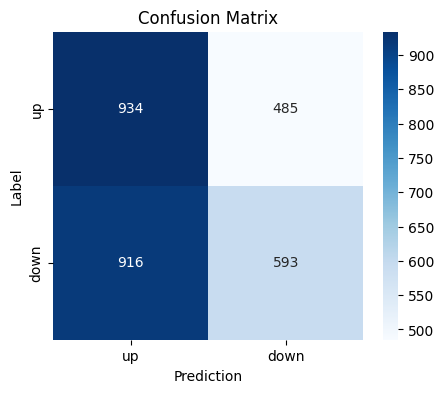

In [46]:
from datetime import timedelta, datetime

sectors=['산업재', '정보기술']
df = pd.read_csv('preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8')
df['upload_dt'] = pd.to_datetime(df['upload_dt'])

### LLM 예측에 실제 등락 라벨 추가 ###
df["code"] = df["code"].astype(str).str.zfill(6)

price_upload = [] # 업로드 당일 종가
price_after_week = [] # 공시 당일 종가
for row in tqdm(df.itertuples(), total=len(df)):
    df_price = pd.read_csv(f"data_kr/price/{row.code}.csv")
    df_price['날짜'] = pd.to_datetime(df_price['날짜'])
    ### 업로드 날짜 직전 종가
    price_upload.append(df_price.loc[df_price["날짜"] < row.upload_dt, "종가"].iloc[-1] if not pd.isna(row.upload_dt) else None)
    ### 업로드 날짜 일주일 후 종가
    after_week_date = row.upload_dt + timedelta(days=7)
    price_after_week.append(df_price.loc[df_price["날짜"] >= after_week_date, "종가"].iloc[0] if not pd.isna(after_week_date) else None)

df["price_upload"] = price_upload
df["price_after_week"] = price_after_week
label = df["price_upload"] < df["price_after_week"] # (업로드 당일 종가)보다 (업로드 일주일 후 종가)가 올랐는가?
df["label"] = ["up" if l == True else "down" if l == False else None for l in label]

df.to_csv("preprocessed_data/llm/predict_total/predict_accuracy.csv", index=False, encoding="utf-8")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 데이터
invalid_list = ((df['prediction'] == '긍정적') | (df['prediction'] == '부정적'))
prediction = df[invalid_list]['prediction']
label = df[invalid_list]['label']

mapping = {'긍정적': 'up', '부정적': 'down'}
prediction = [mapping[l] for l in prediction]

# 혼동 행렬
cm = confusion_matrix(label, prediction, labels=["up", "down"])

# 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["up", "down"], yticklabels=["up", "down"])
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.savefig("preprocessed_data/llm/predict_total/confusion_matrix.png")